# Importations et directories

In [1]:
import sys
MOD_DIR = '/home/16012858/g2p_dir/game-learning'

if MOD_DIR not in sys.path:
    sys.path.append(MOD_DIR)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ml_insights as mli
import xgboost as xgb

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, log_loss, roc_auc_score, brier_score_loss, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.isotonic import IsotonicRegression
from mod.LoL_classification import *

['/home/16012858',
 '/home/16012858/g2p_venv_conda/lib/python310.zip',
 '/home/16012858/g2p_venv_conda/lib/python3.10',
 '/home/16012858/g2p_venv_conda/lib/python3.10/lib-dynload',
 '',
 '/home/16012858/g2p_venv_conda/lib/python3.10/site-packages',
 '/vol/frma2133/PRG0023-Technology_Research_Program/B2720-Information_Content_Services/WP2-Genotype_to_Phenotype/Studies/WP3_1/490-model-calibration/src/pyg2pmodel',
 '/home/16012858/g2p_dir/game-learning']

In [81]:
# INPUT_DIR = "./data/Lol_data.csv"

In [82]:
INPUT_DIR = f"{MOD_DIR}/data/Lol_data.csv"

# Description des données et pre-processing

## Introduction à League of Legends

Il s'agit du plus grand jeu en ligne de tous les temps et nous nous posons la question suivante: est-il possible de prédire l'issue d'un match en se basant sur les statistiques des 10 premières minutes ?

League of Legends est un jeu de stratégie en équipe où deux équipes de cinq puissants champions s'affrontent pour détruire la base de l'autre. 

Les bases du jeu sont les suivantes:

- Les joueurs accumulent de l'or et de l'expérience en tuant des serviteurs, des monstres, d'autres joueurs et des tours.
- Les gardes permettent de voir sur la carte les personnes qui viennent nous tuer.
- L'objectif principal du jeu est de détruire un certain nombre de tours afin de détruire la base de l'adversaire.

Nous vous résumons tout ceci en image:

![Mon image](img_lol.PNG)

## Exploration de nos données

### Analyse basique de notre jeu de données

In [83]:
data = pd.read_csv(INPUT_DIR)
data.head(20)

,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,4519157822,0,28,2,1,9,6,11,0,0,...,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,4523371949,0,12,1,0,5,5,5,0,0,...,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,4521474530,0,15,0,0,7,11,4,1,1,...,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
3,4524384067,0,43,1,0,4,5,5,1,0,...,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4,4436033771,0,75,4,0,6,6,6,0,0,...,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4
5,4475365709,1,18,0,0,5,3,6,1,1,...,0,15201,7.0,18060,221,59,-698,-101,22.1,1520.1
6,4493010632,1,18,3,1,7,6,7,1,1,...,0,14463,6.4,15404,164,35,-2411,-1563,16.4,1446.3
7,4496759358,0,16,2,0,5,13,3,0,0,...,0,17920,6.6,16938,157,54,2615,800,15.7,1792.0
8,4443048030,0,16,3,0,7,7,8,0,0,...,0,18380,7.2,19298,240,53,1979,771,24.0,1838.0
9,4509433346,1,13,1,1,4,5,5,1,1,...,0,16605,6.8,18379,247,43,1548,1574,24.7,1660.5


In [84]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9879 entries, 0 to 9878
Data columns (total 40 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   gameId                        9879 non-null   int64  
 1   blueWins                      9879 non-null   int64  
 2   blueWardsPlaced               9879 non-null   int64  
 3   blueWardsDestroyed            9879 non-null   int64  
 4   blueFirstBlood                9879 non-null   int64  
 5   blueKills                     9879 non-null   int64  
 6   blueDeaths                    9879 non-null   int64  
 7   blueAssists                   9879 non-null   int64  
 8   blueEliteMonsters             9879 non-null   int64  
 9   blueDragons                   9879 non-null   int64  
 10  blueHeralds                   9879 non-null   int64  
 11  blueTowersDestroyed           9879 non-null   int64  
 12  blueTotalGold                 9879 non-null   int64  
 13  blu

Nous allons faire une classification binaire sur nos données en essayant de prédire la victoire ou non de l'équipe bleue en fonction des statistiques de la partie pendant les 10 premières minutes. X constitue le jeu de données contenant les statistiques de la partie et y est la colonne des étiquettes 0 ou 1 (défaite ou victoire des bleus):

In [85]:
y = data["blueWins"]

drop_cols = ['gameId','blueWins']
X = data.drop(drop_cols, axis=1)

X.head()

,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,blueTowersDestroyed,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,28,2,1,9,6,11,0,0,0,0,...,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,12,1,0,5,5,5,0,0,0,0,...,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,15,0,0,7,11,4,1,1,0,0,...,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
3,43,1,0,4,5,5,1,0,1,0,...,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4,75,4,0,6,6,6,0,0,0,0,...,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4


### Répartition des issues de parties

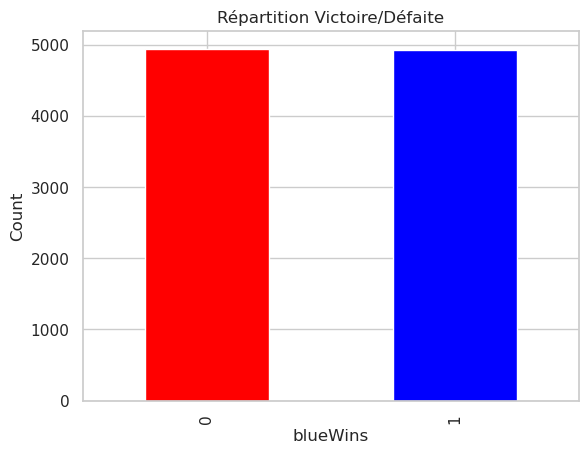

Red Wins: 4949 (50.096%), Blue Wins: 4930(49.904%)


In [86]:
counts = y.value_counts()
counts.plot(kind='bar', color=['red', 'blue'])

plt.xlabel('blueWins')
plt.ylabel('Count')
plt.title('Répartition Victoire/Défaite')
plt.show()

W, L = y.value_counts()

print('Red Wins: {} ({}%), Blue Wins: {}({}%)'.format(W,round(100*W/(W+L),3),L,round(100*L/(W+L),3)))

Notre ensemble de données fournit presque 50/50 de données pour notre variable cible, ce qui signifie qu'il n'y a pas de déséquilibre.

## Pré-processing

### Description de nos données

In [87]:
data.describe()

,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
count,9.879000e+03,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,...,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000
mean,4.500084e+09,0.499038,22.288288,2.824881,0.504808,6.183925,6.137666,6.645106,0.549954,0.361980,...,0.043021,16489.041401,6.925316,17961.730438,217.349226,51.313088,-14.414111,33.620306,21.734923,1648.904140
std,2.757328e+07,0.500024,18.019177,2.174998,0.500002,3.011028,2.933818,4.064520,0.625527,0.480597,...,0.216900,1490.888406,0.305311,1198.583912,21.911668,10.027885,2453.349179,1920.370438,2.191167,149.088841
min,4.295358e+09,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,11212.000000,4.800000,10465.000000,107.000000,4.000000,-11467.000000,-8348.000000,10.700000,1121.200000
25%,4.483301e+09,0.000000,14.000000,1.000000,0.000000,4.000000,4.000000,4.000000,0.000000,0.000000,...,0.000000,15427.500000,6.800000,17209.500000,203.000000,44.000000,-1596.000000,-1212.000000,20.300000,1542.750000
50%,4.510920e+09,0.000000,16.000000,3.000000,1.000000,6.000000,6.000000,6.000000,0.000000,0.000000,...,0.000000,16378.000000,7.000000,17974.000000,218.000000,51.000000,-14.000000,28.000000,21.800000,1637.800000
75%,4.521733e+09,1.000000,20.000000,4.000000,1.000000,8.000000,8.000000,9.000000,1.000000,1.000000,...,0.000000,17418.500000,7.200000,18764.500000,233.000000,57.000000,1585.500000,1290.500000,23.300000,1741.850000
max,4.527991e+09,1.000000,250.000000,27.000000,1.000000,22.000000,22.000000,29.000000,2.000000,1.000000,...,2.000000,22732.000000,8.200000,22269.000000,289.000000,92.000000,10830.000000,9333.000000,28.900000,2273.200000


Chez les bleus comme chez les rouges, le total d'or et le total de CS par minions tués (CSPerMin et GoldPerMin) ont un tres faible écart-type (<10% de la moyenne). On peut donc décider d'enlever ces variables.

In [88]:
X.drop(['blueCSPerMin','blueGoldPerMin','redCSPerMin','redGoldPerMin'], axis=1, inplace=True)

Nous allons enlever les variables inutiles associées à l'équipe rouge, qui sont le reflet des performances de l'équipe bleu. En effet, le nombre de morts dans l'équipe bleu correspond par exemple au nombre d'ennemis tués (kills) dans l'équipe rouge. 'redFirstBlood' est une variable égale à 1 si les rouges réalisent le premier kill et à 0 sinon. Donc, cela n'apporte pas d'information supplémentaire par rapport à 'blueFirstBlood'. De même pour les variables gold et experience diff: Le différentiel d'or/expérience chez les bleus est le négatif exact du différentiel d'or / expérience chez les rouges (GoldDiff et ExperienceDiff).

Les monstres d'élite ('Elite monsters') sont égaux à la somme des Dragons + Heralds. Les variables EliteMonsters n'apportent donc pas d'information non plus.

In [89]:
X.drop(['redFirstBlood','redKills','redDeaths','blueEliteMonsters', 'redEliteMonsters'
             ,'redGoldDiff','redExperienceDiff'], axis=1, inplace=True)

### Corrélation entre les données

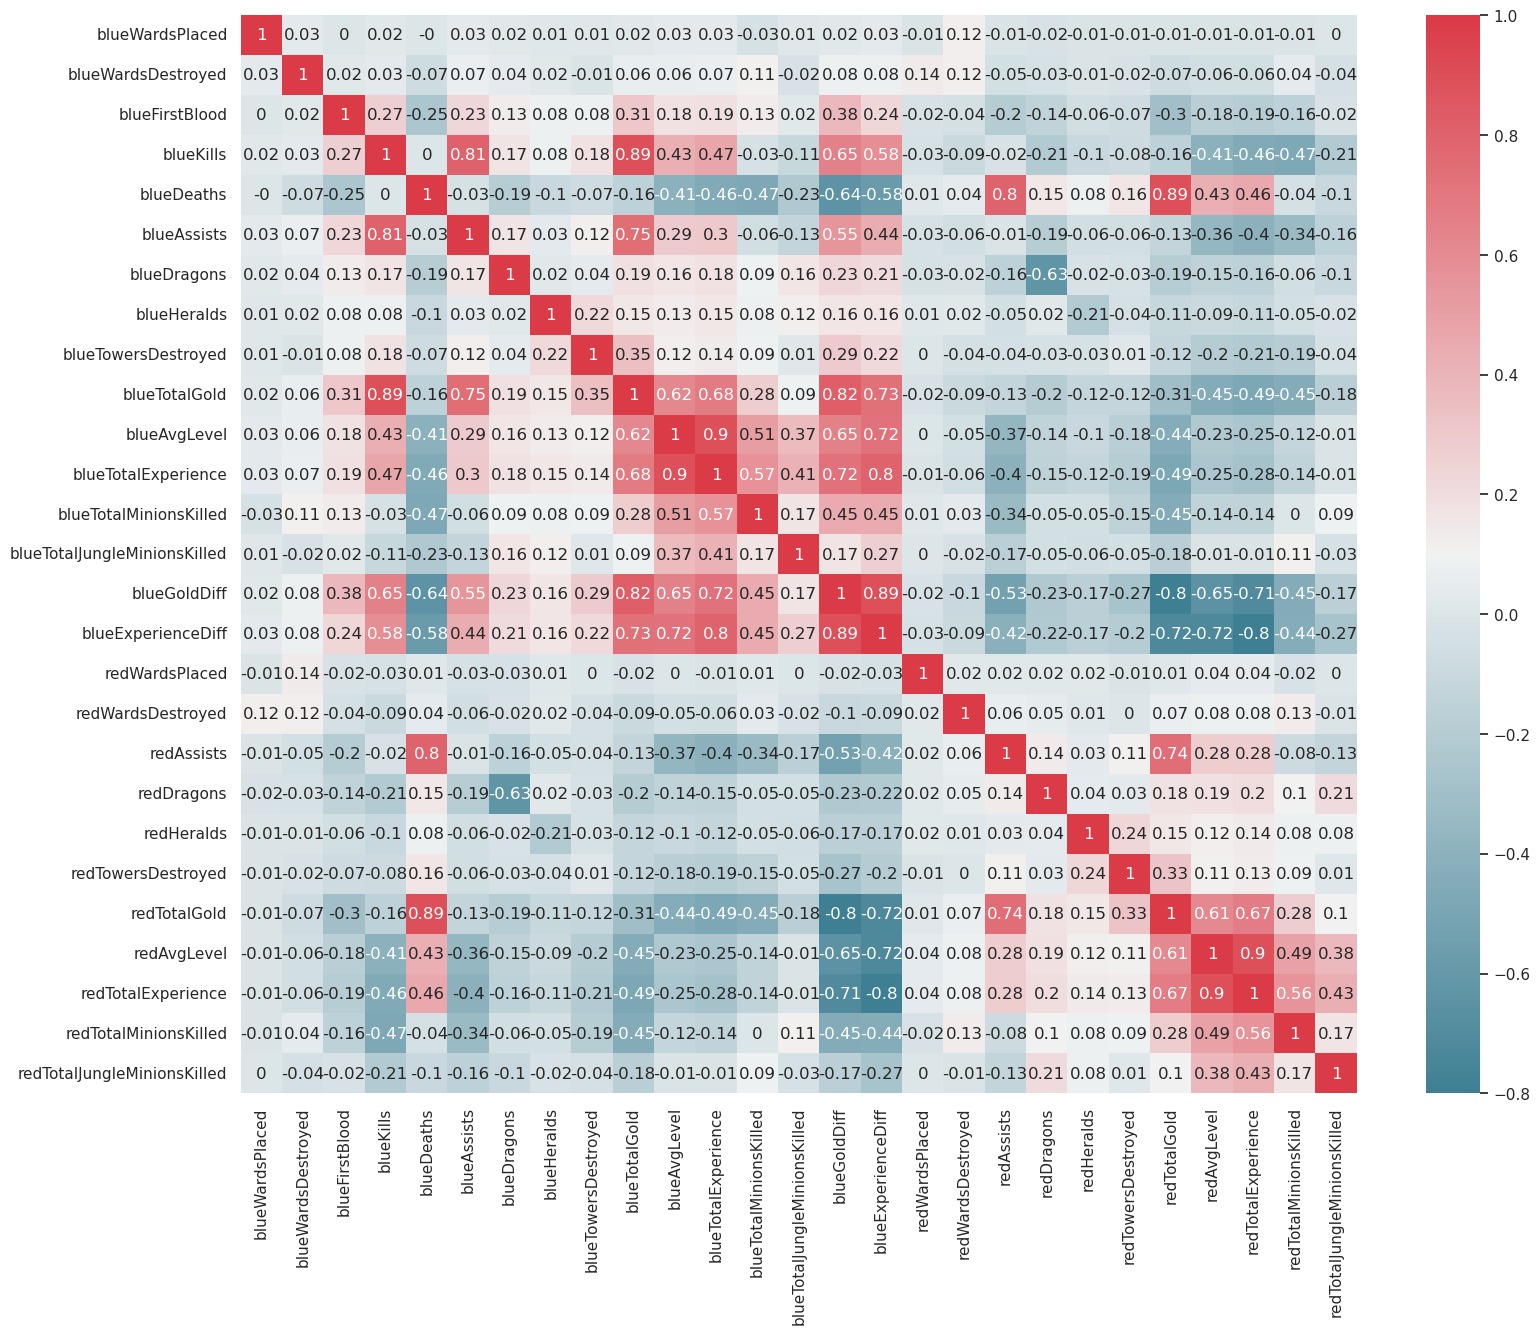

In [90]:
plt.figure(figsize=(18,14))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(round(X.corr(),2), cmap=cmap, annot=True)
plt.show()

On remarque que les données "redAvgLevel" et "blueAvgLevel" sont des informations assez redondantes par rapport aux variables "redTotalExperience" et "blueTotalExperience". De plus, cela semble logique car le niveau d'une équipe est directement correlé à son expérience total (voir schéma). On peut les exclure:

In [91]:
X.drop(["redAvgLevel","blueAvgLevel"], axis=1, inplace=True)

### Gestion des kills, morts et assists

Lorsqu'on s'intéresse à la performance d'une équipe en termes de kills et de morts au sein de l'équipe, on s'intéresse surtout à la différence des deux variables, de même pour les assistances (lorsqu'un joueur participe à la mort d'un ennemi mais ne le tue pas directement). On peut donc introduire deux nouvelles variables et suppimer les variables assists et kills:

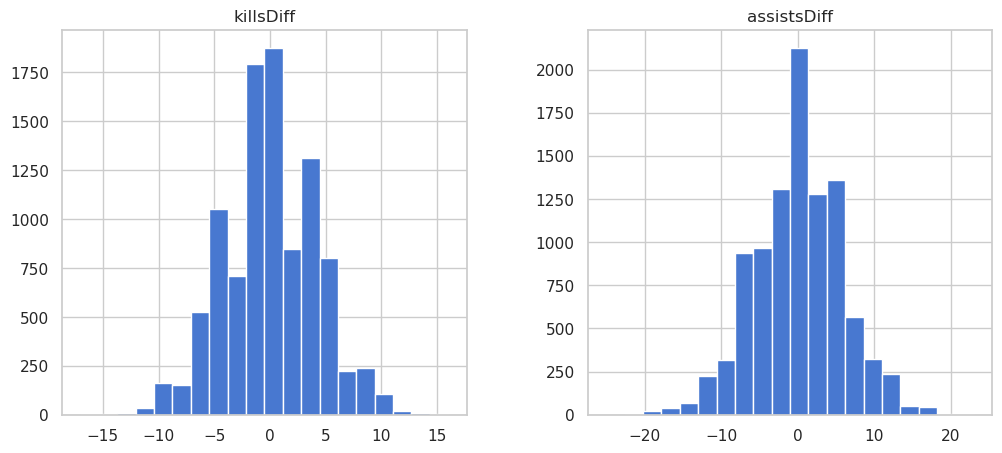

In [92]:
X['killsDiff'] = X['blueKills'] - X['blueDeaths']
X['assistsDiff'] = X['blueAssists'] - X['redAssists']

X[['killsDiff','assistsDiff']].hist(figsize=(12,5), bins=20)
plt.show()

La distribution des kills, des morts et des assists semble similaire entre les rouges et les bleus puisque les histogrammes sont centrés en 0.

In [93]:
X.drop(['blueKills','blueDeaths','blueAssists','redAssists'], axis=1, inplace=True)

L'importance de killsDiff et assistsDiff sur le résultat d'un jeu peut être illustrée ci-dessous. Lorsque le résultat n'est pas uniquement représenté par ces caractéristiques, il y a une corrélation évidente:

/home/16012858/g2p_venv_conda/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 43.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/16012858/g2p_venv_conda/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 28.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/16012858/g2p_venv_conda/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 93.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/16012858/g2p_venv_conda/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 56.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/16012858/g2p_venv_conda/lib/python

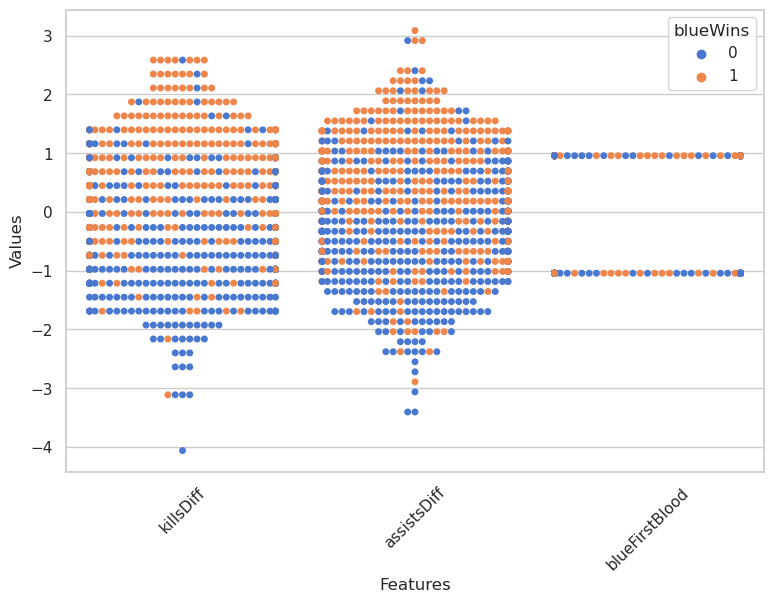

In [94]:
sns.set(style='whitegrid', palette='muted')

X_diff = X[['killsDiff','assistsDiff', 'blueFirstBlood']].sample(1000)
X_diff_std = (X_diff - X_diff.mean()) / X_diff.std()
X_diff = pd.concat([y, X_diff_std], axis=1)
X_diff = pd.melt(X_diff, id_vars='blueWins', var_name='Features', value_name='Values')

plt.figure(figsize=(9,6))
sns.swarmplot(x='Features', y='Values', hue='blueWins', data=X_diff)
plt.xticks(rotation=45)
plt.show()

### Gestion des gardes (wards)

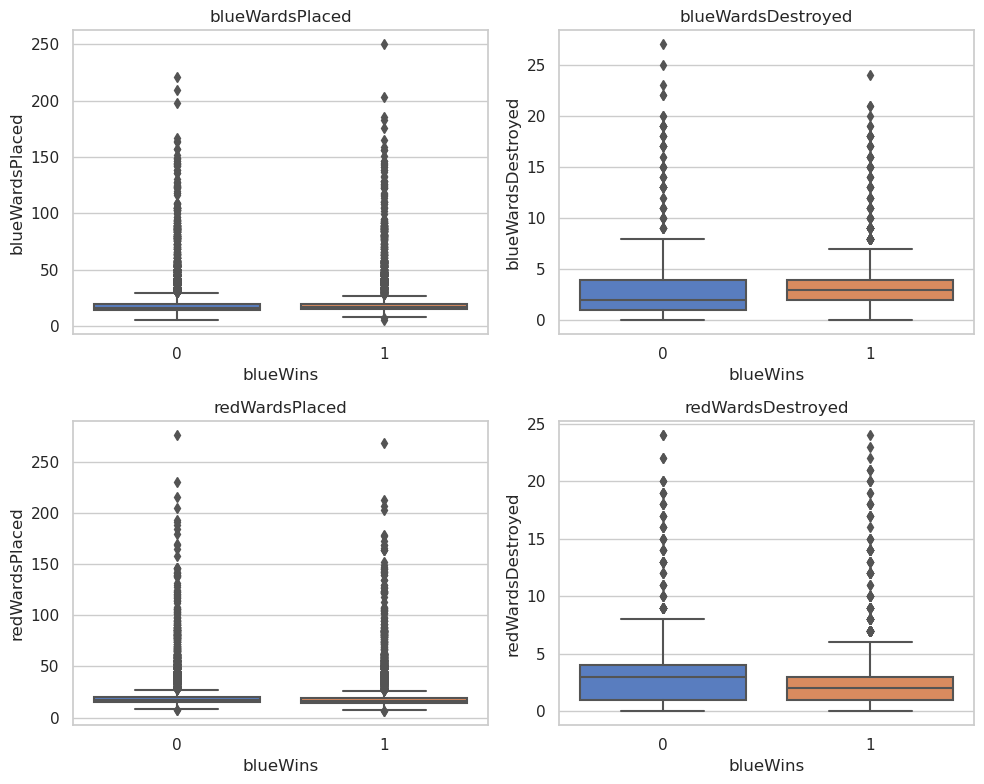

In [95]:
variables = ['blueWardsPlaced','blueWardsDestroyed','redWardsPlaced','redWardsDestroyed']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

for i, var in enumerate(variables):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    sns.boxplot(x=y, y=var, data=X, ax=ax)
    ax.set_title(var)
    

plt.tight_layout()

plt.show()

Par connaissance du jeu, on peut partir du principe que la mise en place et la destruction de gardes (wards) est assez systématique et qu'il n'y a donc pas beaucoup de variance dans les données, comme le suggèrent les boxplots ci-dessus.

In [96]:
X.drop(['blueWardsPlaced','blueWardsDestroyed','redWardsPlaced','redWardsDestroyed'], axis=1, inplace=True)

### Gestion de la variable "FirstBlood"

Au contraire, la répartition des victoires/défaites semble équitable entre les parties où les bleus font le premier kill (blueFirstBlood = 0) et les parties où ce sont les rouges qui font le premier kill. C'est assez logique car le premier kill est une performance individuelle qui indique peu de chose pour la suite de la partie. Cela peut se confirmer ci-dessous:

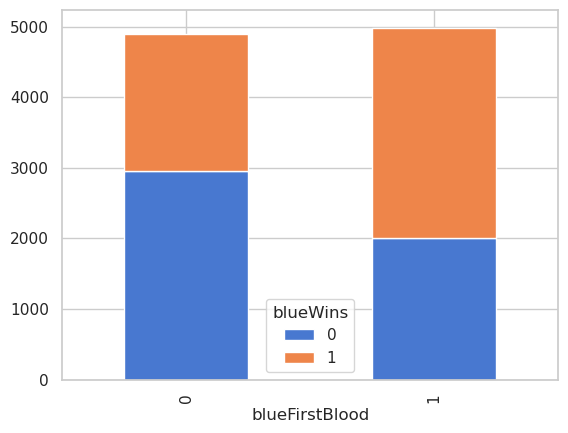

In [97]:
bFB_counts = pd.crosstab(X['blueFirstBlood'], y)

ax = bFB_counts.plot.bar(stacked=True)
ax.set_xlabel('blueFirstBlood')
plt.show()

In [98]:
X.drop(['blueFirstBlood'], axis=1, inplace=True)

### Gestion de l'or et de l'expérience

On peut supprimer les TotalGold et TotalExperience car il existe déjà des variables GoldDiff et ExperienceDiff qui les caractérisent très bien:

In [99]:
X.drop(['blueTotalGold','blueTotalExperience','redTotalGold','redTotalExperience'], axis=1, inplace=True)

La combinaison des variables GoldDiff et ExperienceDiff semble être très intéressante pour expliquer la victoire ou non de l'équipe bleue:

<Axes: xlabel='blueExperienceDiff', ylabel='blueGoldDiff'>

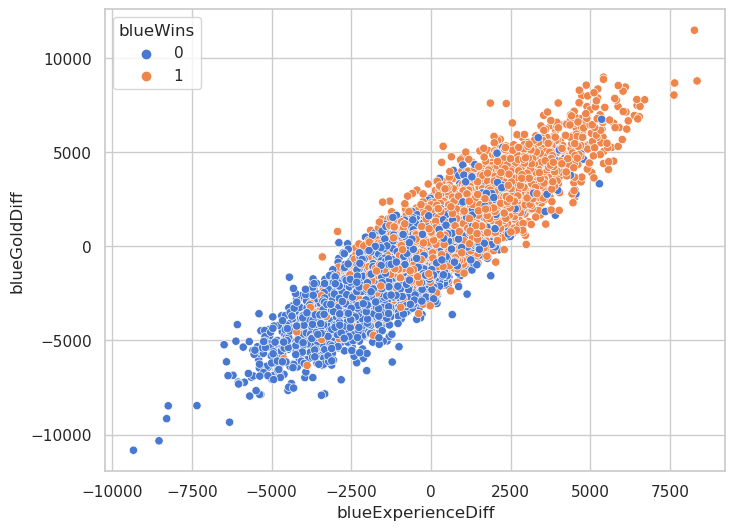

In [100]:
data_concat = pd.concat([y, X], axis=1)

plt.figure(figsize=(8,6))
sns.scatterplot(x='blueExperienceDiff', y='blueGoldDiff', hue='blueWins', data=data_concat)

### Gestion des dragons et des heralds

Comme pour les kills et les assists, les Dragons et les Heralds chez les rouges et les bleus sont aussi intéressants individuellement que leur différence entre chaque équipe. Autant créer des variables dragonDiff et heraldsDiff dans ce cas:

In [101]:
X['dragonsDiff'] = X['blueDragons'] - X['redDragons']
X['heraldsDiff'] = X['blueHeralds'] - X['redHeralds']

X.drop(['blueDragons','blueHeralds','redDragons','redHeralds'], axis=1, inplace=True)

### Gestion des tours et des minions

De même pour les tours détruites de chaque côté, ainsi que les Minions tués:

In [102]:
X['towerDiff'] = X['blueTowersDestroyed'] - X['redTowersDestroyed']
X['minionsDiff'] = X['blueTotalMinionsKilled'] - X['redTotalMinionsKilled']
X['jungleMinionDiff'] = X['blueTotalJungleMinionsKilled'] - X['redTotalJungleMinionsKilled']

X.drop(['blueTowersDestroyed','redTowersDestroyed', 'blueTotalMinionsKilled','blueTotalJungleMinionsKilled',
      'redTotalMinionsKilled','redTotalJungleMinionsKilled'], axis=1, inplace=True)

Les tours représentent un objectif majeur pour chaque équipe et nous devrions donc nous attendre à ce qu'il ait une grande influence sur l'issue du match.

Le graphique ci-dessous montre que la destruction d'une tour confère un avantage considérable à une équipe:

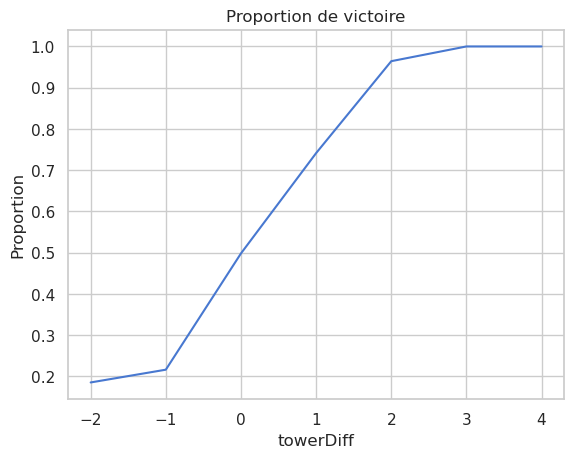

In [103]:
data_concat = pd.concat([y, X], axis=1)

towerGroup = data_concat.groupby(['towerDiff'])['blueWins']
towerGroup.mean().plot(kind='line')
plt.title('Proportion de victoire')
plt.ylabel('Proportion')
plt.show()

/home/16012858/g2p_venv_conda/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 8.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/16012858/g2p_venv_conda/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 12.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/16012858/g2p_venv_conda/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 8.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


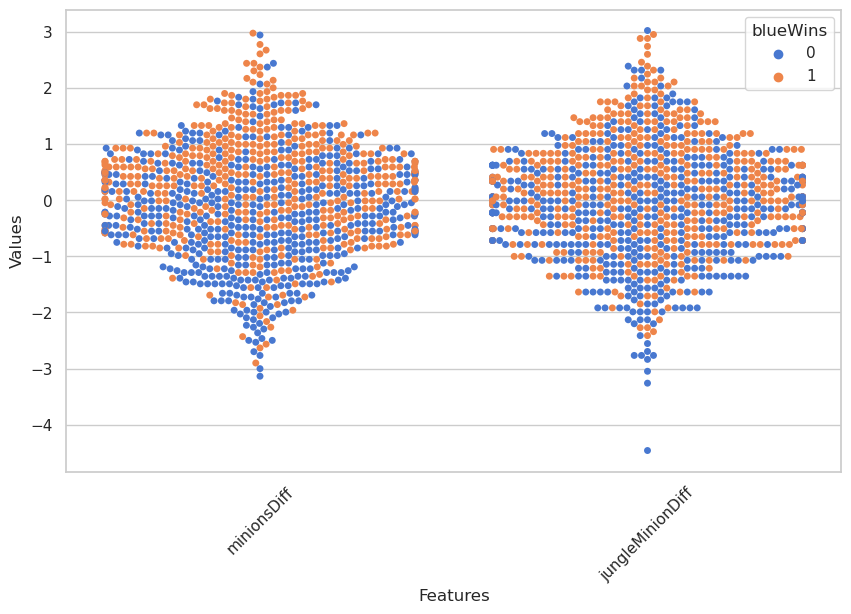

In [104]:
sns.set(style='whitegrid', palette='muted')

data = X[['minionsDiff', 'jungleMinionDiff']].sample(1000)
data_std = (data - data.mean()) / data.std()
data = pd.concat([y, data_std], axis=1)
data = pd.melt(data, id_vars='blueWins', var_name='Features', value_name='Values')

plt.figure(figsize=(10,6))
sns.swarmplot(x='Features', y='Values', hue='blueWins', data=data)
plt.xticks(rotation=45)
plt.show()

D'après le plot ci-dessus, nous pouvons enlever l'information des jungle minions. En ce qui concerne les minions, c'est moins évident. Nous décidons de créer deux jeux de données: un avec et un sans les minions.

In [105]:
X_wm = X.copy()
X_wm.drop(['jungleMinionDiff'], axis=1, inplace=True) #Jeu avec les minions.
X.drop(['minionsDiff', 'jungleMinionDiff'], axis=1, inplace=True) #Jeu sans.

### Jeux de données finaux

On termine donc avec les jeux de données simplifiés:

In [106]:
print(X.shape, X_wm.shape, y.shape)
X.head(10)

(9879, 7) (9879, 8) (9879,)


,blueGoldDiff,blueExperienceDiff,killsDiff,assistsDiff,dragonsDiff,heraldsDiff,towerDiff
0,643,-8,3,3,0,0,0
1,-2908,-1173,0,3,-1,-1,-1
2,-1172,-1033,-4,-10,1,0,0
3,-1321,-7,-1,-5,0,1,0
4,-1004,230,0,-1,-1,0,0
5,698,101,2,4,1,0,0
6,2411,1563,1,-2,1,0,0
7,-2615,-800,-8,-8,-1,0,0
8,-1979,-771,0,3,-1,-1,0
9,-1548,-1574,-1,1,1,0,0


In [107]:
X_wm.head(10)

,blueGoldDiff,blueExperienceDiff,killsDiff,assistsDiff,dragonsDiff,heraldsDiff,towerDiff,minionsDiff
0,643,-8,3,3,0,0,0,-2
1,-2908,-1173,0,3,-1,-1,-1,-66
2,-1172,-1033,-4,-10,1,0,0,-17
3,-1321,-7,-1,-5,0,1,0,-34
4,-1004,230,0,-1,-1,0,0,-15
5,698,101,2,4,1,0,0,4
6,2411,1563,1,-2,1,0,0,61
7,-2615,-800,-8,-8,-1,0,0,52
8,-1979,-771,0,3,-1,-1,0,-51
9,-1548,-1574,-1,1,1,0,0,-27


# Apprentissage supervisé: Classification binaire à l'aide de différents modèles

Il est recommandé d'appliquer un scaler sur des données si les valeurs des différentes variables ont des échelles différentes:

In [108]:
X = StandardScaler().fit(X).transform(X.astype(float))
X_wm = StandardScaler().fit(X_wm).transform(X_wm.astype(float))

In [109]:
train_size = 0.8
test_size = 1 - train_size
rs = 42

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=rs)
X_wm_train, X_wm_test, y_train, y_test = train_test_split(X_wm, y, test_size=test_size, random_state=rs)

In [111]:
print ('Train set classique:', X_train.shape,  y_train.shape)
print ('Test set classique:', X_test.shape,  y_test.shape)
print ('Train set avec les minions:', X_wm_train.shape,  y_train.shape)
print ('Test set avec les minions:', X_wm_test.shape,  y_test.shape)

Train set classique: (7903, 7) (7903,)
Test set classique: (1976, 7) (1976,)
Train set avec les minions: (7903, 8) (7903,)
Test set avec les minions: (1976, 8) (1976,)


In [112]:
table = pd.DataFrame(columns=['Algorithme', 'Accuracy', 'Rappel', 'Précision', 'F-Score'])
table_wm = table.copy()

Le paramètre class_weight, présent dans de nombreux algorithmes de machine learning, permet de conférer un poids aux différentes classes de la variable cible. Nos classes n'étant pas déséquilibrées, nous ne l'utiliserons pas.

## Arbres de décision

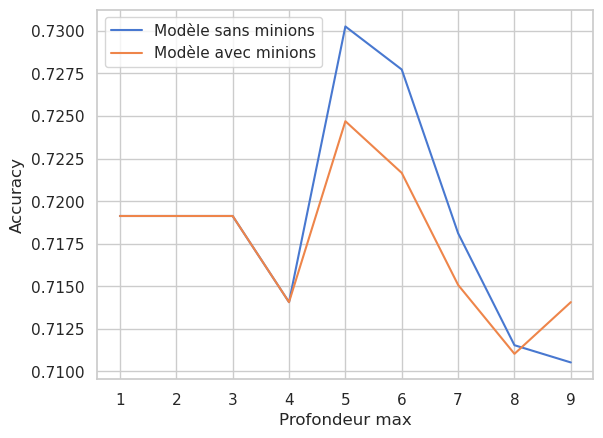

In [113]:
x = range(1, 10)
accuracy_tree = []
accuracy_tree_wm = []

for i in x:
    tree = DecisionTreeClassifier(criterion="entropy", max_depth = i)

    tree.fit(X_train,y_train)
    y_pred = tree.predict(X_test)
    accuracy_tree.append(accuracy_score(y_test, y_pred))

    tree.fit(X_wm_train, y_train)
    y_pred_wm = tree.predict(X_wm_test)
    accuracy_tree_wm.append(accuracy_score(y_test, y_pred_wm))

plt.plot(x, accuracy_tree, label='Modèle sans minions')
plt.plot(x, accuracy_tree_wm, label='Modèle avec minions')
plt.xlabel("Profondeur max")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

On remarque qu'il y a un optimum de performance, indépendamment de la prise en compte de la variable minionsDiff, pour un arbre de décision avec une profondeur maximale de 5. Nous allons donc garder cette valeur.

In [114]:
tree = DecisionTreeClassifier(criterion="entropy", max_depth = 5)

tree.fit(X_train,y_train)
y_pred = tree.predict(X_test)

tree.fit(X_wm_train, y_train)
y_pred_wm = tree.predict(X_wm_test)

In [115]:
algorithm, accuracy, recall, precision, f_score = get_metrics('DecisionTree', y_pred, y_test)
table = table.append({'Algorithme': algorithm, 'Accuracy': round(accuracy,5), 'Rappel': round(recall,5), 'Précision':round(precision,5), 'F-Score':round(f_score,5)}, ignore_index=True)

algorithm, accuracy, recall, precision, f_score = get_metrics('DecisionTree', y_pred_wm, y_test)
table_wm = table_wm.append({'Algorithme': algorithm, 'Accuracy': round(accuracy,5), 'Rappel': round(recall,5), 'Précision':round(precision,5), 'F-Score':round(f_score,5)}, ignore_index=True)

/tmp/ipykernel_1126/3847129897.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Algorithme': algorithm, 'Accuracy': round(accuracy,5), 'Rappel': round(recall,5), 'Précision':round(precision,5), 'F-Score':round(f_score,5)}, ignore_index=True)
/tmp/ipykernel_1126/3847129897.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_wm = table_wm.append({'Algorithme': algorithm, 'Accuracy': round(accuracy,5), 'Rappel': round(recall,5), 'Précision':round(precision,5), 'F-Score':round(f_score,5)}, ignore_index=True)


## K-Nearest Neighbours

L'algorithme des K plus proches voisins (KNN) possède comme argument la valeur k, correspondant au nombre de voisins les plus proches à considérer lors de la prédiction de la classe. Ici, nous utilisons une fonction présente dans le module Lol_classification.py (fichier mod) afin de trouver le k optimal entre 1 et 10.

In [116]:
nb_cluster = 10
best_k = [find_best_k(nb_cluster, X_train, y_train, X_test, y_test), find_best_k(nb_cluster, X_wm_train, y_train, X_wm_test, y_test)]

knn = KNeighborsClassifier(n_neighbors = best_k[0]).fit(X_train,y_train)
knn_wm = KNeighborsClassifier(n_neighbors = best_k[1]).fit(X_wm_train,y_train)

y_pred = knn.predict(X_test)
y_pred_wm = knn_wm.predict(X_wm_test)

In [117]:
algorithm, accuracy, recall, precision, f_score = get_metrics('KNN', y_pred, y_test)
table = table.append({'Algorithme': algorithm, 'Accuracy': round(accuracy,5), 'Rappel': round(recall,5), 'Précision':round(precision,5), 'F-Score':round(f_score,5)}, ignore_index=True)

algorithm, accuracy, recall, precision, f_score = get_metrics('KNN', y_pred_wm, y_test)
table_wm = table_wm.append({'Algorithme': algorithm, 'Accuracy': round(accuracy,5), 'Rappel': round(recall,5), 'Précision':round(precision,5), 'F-Score':round(f_score,5)}, ignore_index=True)

/tmp/ipykernel_1126/1034258505.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Algorithme': algorithm, 'Accuracy': round(accuracy,5), 'Rappel': round(recall,5), 'Précision':round(precision,5), 'F-Score':round(f_score,5)}, ignore_index=True)
/tmp/ipykernel_1126/1034258505.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_wm = table_wm.append({'Algorithme': algorithm, 'Accuracy': round(accuracy,5), 'Rappel': round(recall,5), 'Précision':round(precision,5), 'F-Score':round(f_score,5)}, ignore_index=True)


## Régression logistique

La valeur C dans la régression logistique est un paramètre de régularisation qui contrôle la pénalisation pour les coefficients du modèle. Une valeur de C plus élevée signifie une pénalité plus faible et une forte adaptation aux données d'entraînement, tandis qu'une valeur de C plus faible signifie une pénalité plus forte et une meilleure généralisation du modèle.

En ajustant les valeurs de C pour chaque sous-ensemble et en moyennant les résultats de l'évaluation, la cross-validation peut aider à éviter le sur-ajustement du modèle aux données d'entraînement et à trouver le meilleur compromis entre la complexité du modèle et sa capacité à généraliser aux données de test.

In [118]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(LogisticRegression(solver='liblinear'), param_grid, cv=5)

grid.fit(X_train, y_train)
best_C = grid.best_params_['C']

grid.fit(X_wm_train, y_train)
best_C_wm = grid.best_params_['C']

best_C, best_C_wm

(1, 10)

Les meilleures valeurs de C retenues sont 1 pour le modèle classique, et 10 pour le modèle avec les minions:

In [119]:
LR = LogisticRegression(C=1, solver='liblinear')
LR_wm = LogisticRegression(C=10, solver='liblinear')

LR.fit(X_train,y_train)
y_pred = LR.predict(X_test)

LR_wm.fit(X_wm_train,y_train)
y_pred_wm = LR_wm.predict(X_wm_test)

In [120]:
algorithm, accuracy, recall, precision, f_score = get_metrics('LogReg', y_pred, y_test)
table = table.append({'Algorithme': algorithm, 'Accuracy': round(accuracy,5), 'Rappel': round(recall,5), 'Précision':round(precision,5), 'F-Score':round(f_score,5)}, ignore_index=True)

algorithm, accuracy, recall, precision, f_score = get_metrics('LogReg', y_pred_wm, y_test)
table_wm = table_wm.append({'Algorithme': algorithm, 'Accuracy': round(accuracy,5), 'Rappel': round(recall,5), 'Précision':round(precision,5), 'F-Score':round(f_score,5)}, ignore_index=True)

/tmp/ipykernel_1126/1232484415.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Algorithme': algorithm, 'Accuracy': round(accuracy,5), 'Rappel': round(recall,5), 'Précision':round(precision,5), 'F-Score':round(f_score,5)}, ignore_index=True)
/tmp/ipykernel_1126/1232484415.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_wm = table_wm.append({'Algorithme': algorithm, 'Accuracy': round(accuracy,5), 'Rappel': round(recall,5), 'Précision':round(precision,5), 'F-Score':round(f_score,5)}, ignore_index=True)


## SVM

Les paramètres de SVM, C et gamma, ont été choisi grâce à une cross-validation. Pour lancer le code qui exécute la cross-validation avec grid search, il faut décommenter la cellule suivante:

In [121]:
# param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1]}
# svm = SVC(kernel='rbf')

# grid = GridSearchCV(svm, param_grid, cv=5)
# grid.fit(X_train, y_train)

# print("Meilleurs paramètres : {}".format(grid.best_params_))
# print("Meilleure performance : {:.2f}".format(grid.best_score_))

# grid.fit(X_wm_train, y_train)

# print("Meilleurs paramètres en wm: {}".format(grid.best_params_))
# print("Meilleure performance en wm: {:.2f}".format(grid.best_score_))

Le code tourne pendant environ 5min, et on obtient le résultat suivant:

- Pour le modèle sans les minions:
  - Meilleurs paramètres : {'C': 100, 'gamma': 0.001}
  - Meilleure performance : 0.73
<br/><br/>
- Pour le modèle avec les minions:
  - Meilleurs paramètres : {'C': 1, 'gamma': 0.01}
  - Meilleure performance : 0.73

On utilise donc ces valeurs dans les paramètres de la SVM.

In [122]:
svm = SVC(kernel='rbf', C=100, gamma=0.001)
svm_wm = SVC(kernel='rbf', C=1, gamma=0.01)

svm.fit(X_train,y_train)
y_pred = svm.predict(X_test)

svm_wm.fit(X_wm_train,y_train)
y_pred_wm = svm_wm.predict(X_wm_test)

In [123]:
algorithm, accuracy, recall, precision, f_score = get_metrics('SVM', y_pred, y_test)
table = table.append({'Algorithme': algorithm, 'Accuracy': round(accuracy,5), 'Rappel': round(recall,5), 'Précision':round(precision,5), 'F-Score':round(f_score,5)}, ignore_index=True)

algorithm, accuracy, recall, precision, f_score = get_metrics('SVM', y_pred_wm, y_test)
table_wm = table_wm.append({'Algorithme': algorithm, 'Accuracy': round(accuracy,5), 'Rappel': round(recall,5), 'Précision':round(precision,5), 'F-Score':round(f_score,5)}, ignore_index=True)

/tmp/ipykernel_1126/3689935691.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Algorithme': algorithm, 'Accuracy': round(accuracy,5), 'Rappel': round(recall,5), 'Précision':round(precision,5), 'F-Score':round(f_score,5)}, ignore_index=True)
/tmp/ipykernel_1126/3689935691.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_wm = table_wm.append({'Algorithme': algorithm, 'Accuracy': round(accuracy,5), 'Rappel': round(recall,5), 'Précision':round(precision,5), 'F-Score':round(f_score,5)}, ignore_index=True)


## XG Boost

Nous réalisons une cross-validation avec un grid-search pour déterminer les meilleurs paramètres à utiliser pour l'apprentissage avec le modèle XGBoost. Parmi ces paramètres, nous retrouvons :

- max_depth, qui contrôle la profondeur maximale de chaque arbre de décision. Une valeur plus élevée permet au modèle de s'adapter plus étroitement aux données d'entraînement, mais peut également entraîner un sur-apprentissage et une faible généralisation aux données de test.

- learning_rate, qui détermine la vitesse à laquelle le modèle apprend à partir des erreurs. Une valeur plus élevée permet un apprentissage plus rapide, mais peut également entraîner un sur-apprentissage.

- n_estimators, qui contrôle le nombre d'arbres de décision à entraîner. Une valeur plus élevée peut améliorer la précision du modèle, mais peut également augmenter le temps d'entraînement et la complexité du modèle.

In [124]:
# param_grid = {
#     'max_depth': [3, 4, 5],
#     'learning_rate': [0.1, 0.01, 0.001],
#     'n_estimators': [100, 200, 300]
# }
# mod_xgb = xgb.XGBClassifier()

# grid_search = GridSearchCV(mod_xgb, param_grid=param_grid, cv=5)
# grid_search.fit(X_train, y_train)

# print("Best parameters: ", grid_search.best_params_)

In [125]:
# grid_search_wm = GridSearchCV(mod_xgb, param_grid=param_grid, cv=5)
# grid_search_wm.fit(X_wm_train, y_train)

# print("Best parameters: ", grid_search_wm.best_params_)

Le code tourne pendant environ 6min au total. Les meilleurs paramètres gardés par la cross-validation sont les suivants:
- Données avec les minions: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
- Données sans les minions: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300}

In [126]:
mod_xgb = xgb.XGBClassifier(learning_rate = 0.1, max_depth = 3, n_estimators = 100)
mod_xgb_wm = xgb.XGBClassifier(learning_rate = 0.01, max_depth = 3, n_estimators = 300)

mod_xgb.fit(X_train,y_train)
y_pred = mod_xgb.predict(X_test)

mod_xgb_wm.fit(X_wm_train,y_train)
y_pred_wm = mod_xgb_wm.predict(X_wm_test)

In [127]:
algorithm, accuracy, recall, precision, f_score = get_metrics('XGB', y_pred, y_test)
table = table.append({'Algorithme': algorithm, 'Accuracy': round(accuracy,5), 'Rappel': round(recall,5), 'Précision':round(precision,5), 'F-Score':round(f_score,5)}, ignore_index=True)

algorithm, accuracy, recall, precision, f_score = get_metrics('XGB', y_pred_wm, y_test)
table_wm = table_wm.append({'Algorithme': algorithm, 'Accuracy': round(accuracy,5), 'Rappel': round(recall,5), 'Précision':round(precision,5), 'F-Score':round(f_score,5)}, ignore_index=True)

/tmp/ipykernel_1126/3256166289.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Algorithme': algorithm, 'Accuracy': round(accuracy,5), 'Rappel': round(recall,5), 'Précision':round(precision,5), 'F-Score':round(f_score,5)}, ignore_index=True)
/tmp/ipykernel_1126/3256166289.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_wm = table_wm.append({'Algorithme': algorithm, 'Accuracy': round(accuracy,5), 'Rappel': round(recall,5), 'Précision':round(precision,5), 'F-Score':round(f_score,5)}, ignore_index=True)


## Bilan

In [128]:
table

,Algorithme,Accuracy,Rappel,Précision,F-Score
0,DecisionTree,0.73026,0.73414,0.73046,0.73230
1,KNN,0.71913,0.71400,0.72347,0.71870
2,LogReg,0.73634,0.73817,0.73742,0.73780
3,SVM,0.73279,0.72709,0.73749,0.73225
4,XGB,0.73229,0.72608,0.73722,0.73161


In [129]:
table_wm

,Algorithme,Accuracy,Rappel,Précision,F-Score
0,DecisionTree,0.72470,0.71803,0.72979,0.72386
1,KNN,0.70800,0.70594,0.71095,0.70844
2,LogReg,0.73634,0.73817,0.73742,0.73780
3,SVM,0.73178,0.72508,0.73695,0.73096
4,XGB,0.73128,0.72608,0.73571,0.73087


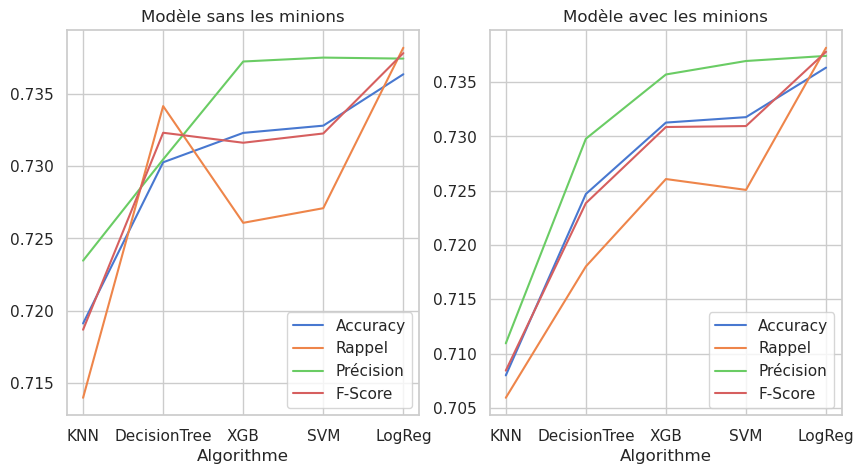

In [130]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

table = table.sort_values(by='Accuracy', ascending=True)
table_wm = table_wm.sort_values(by='Accuracy', ascending=True)

table.plot(x='Algorithme', ax=axes[0])
axes[0].set_title('Modèle sans les minions')

table_wm.plot(x='Algorithme', ax=axes[1])
axes[1].set_title('Modèle avec les minions')

plt.show()

L'ensemble des modèles semblent avoir une accuracy d'environ 0.72-0.73, ce qui est bien mieux que le hasard. Le meilleur modèle semble être la régression logistique: c'est ce modèle qui maximise l'ensemble des métriques qui décrivent la performance d'un modèle. De plus, on se rend compte que l'information "minions" n'apporte pas grand chose à l'apprentissage des modèles. La variable fait d'ailleurs souvent baisser la performance des différents modèles.

Dans la suite de cet exercice, nous allons essayer de calibrer les probabilités associées à chaque prédiction. Pour ceci, nous allons garder uniquement le modèle de régression logistique, les données sans les minions ainsi que les paramètres associés: {C=1, solver='liblinear'}.

# Calibration

Nous allons examiner deux façons d'obtenir un ensemble de données sur lequel effectuer la calibration :

- Utiliser un ensemble de calibration indépendant (approche A),
- Utiliser la cross-validation pour générer des scores à partir de l'ensemble d'apprentissage (approche B).

La première méthode est plus simple, mais elle nécessite un ensemble de données distinct. Étant donné que nous avons un grand nombre de données, cela devrait bien fonctionner.

La seconde approche prend plus de temps, mais est généralement plus efficace. Nous générons un ensemble de prédictions à validation croisée sur les données d'apprentissage. Ces prédictions proviennent de modèles qui sont proches, mais pas exactement identiques, à notre modèle original.

In [131]:
train_perc = .6
calib_perc = .05
test_perc = 1-train_perc-calib_perc
rs = 44

In [132]:
X_train_calib, X_test, y_train_calib, y_test = train_test_split(X, y, test_size=test_perc, random_state=rs)
X_train, X_calib, y_train, y_calib = train_test_split(X_train_calib, y_train_calib, 
                                                              test_size=calib_perc/(1-test_perc), 
                                                              random_state=rs)

In [133]:
model = LogisticRegression(C=1, solver='liblinear')

model.fit(X_train,y_train)

y_prob_uncalib_calib = model.predict_proba(X_calib)[:,1]
y_prob_uncalib_test= model.predict_proba(X_test)[:,1]

## Métriques importantes

### Courbe ROC

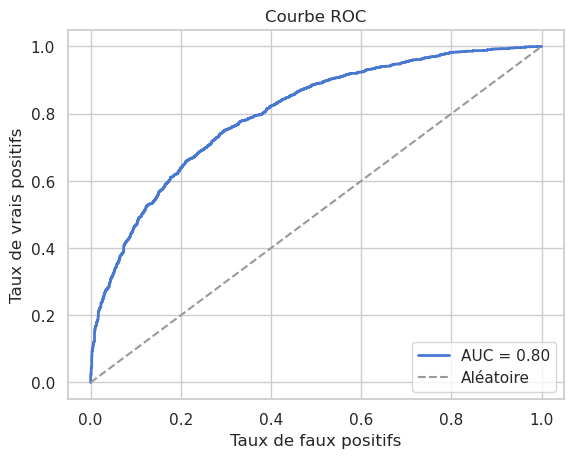

In [134]:
# Calculer la courbe ROC et l'aire sous la courbe (AUC)
fpr, tpr, thresholds = roc_curve(y_test, y_prob_uncalib_test)
roc_auc = auc(fpr, tpr)

# Créer la figure et le sous-plot pour la courbe ROC
fig, ax = plt.subplots()
ax.set_title('Courbe ROC')
ax.set_xlabel('Taux de faux positifs')
ax.set_ylabel('Taux de vrais positifs')
ax.grid(True)

# Tracer la courbe ROC
ax.plot(fpr, tpr, lw=2, label='AUC = %0.2f' % roc_auc)
ax.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Aléatoire')

# Ajouter la légende à la figure
ax.legend(loc="lower right")

### ROC AUC Score vs Log-loss

In [135]:
roc_auc_score(y_test, y_prob_uncalib_test), log_loss(y_test, y_prob_uncalib_test)

(0.8006302333308907, 0.5421769398204449)

La ROC AUC est l'aire sous la courbe ROC. Ainsi, dans le cas parfait, nous approchons de 1 (ou de 0 dans un cas parfaitement imparfait) et dans le pire des cas, nous avons une aire de 0,5.

La logloss indique à quel point nos probabilités de sortie sont proches des vraies valeurs de probabilité. La fonction logarithmique est appliquée à la loss (différence absolue entre la classe et la probabilité) et la moyenne est calculée sur tous les exemples. Dans le cas parfait, la log-loss est égal à 0 : nous sommes sûrs de nos choix (proba = 1 ou 0) et nos choix sont bons. Dans le pire des cas, la log-loss tend vers $+\infty$.

Dans notre cas, le score roc auc est plutôt bon car il s'approche de 1. De même pour les valeurs de brier score et la log loss qui sont assez proches de 0.

### Brier Score

Le score de Brier est une MSE entre la probabilité prédite et la classe. Il pénalise moins l'erreur que le log-loss. Si la probabilité réelle est de 0,01 et la prédiction de 0,0001, il s'agira d'une grosse erreur pour le log-loss et d'une petite erreur pour le Brier.

In [136]:
brier_score_loss(y_test, y_prob_uncalib_test)

0.1826532970371232

### Courbe de calibration

Une courbe de calibration représente la relation entre les prédictions de probabilité d'un modèle de classification binaire et les taux observés de résultats positifs réels. Une courbe de calibration idéale suit une ligne diagonale, indiquant que les prédictions de probabilité du modèle correspondent étroitement aux taux observés de résultats positifs réels.

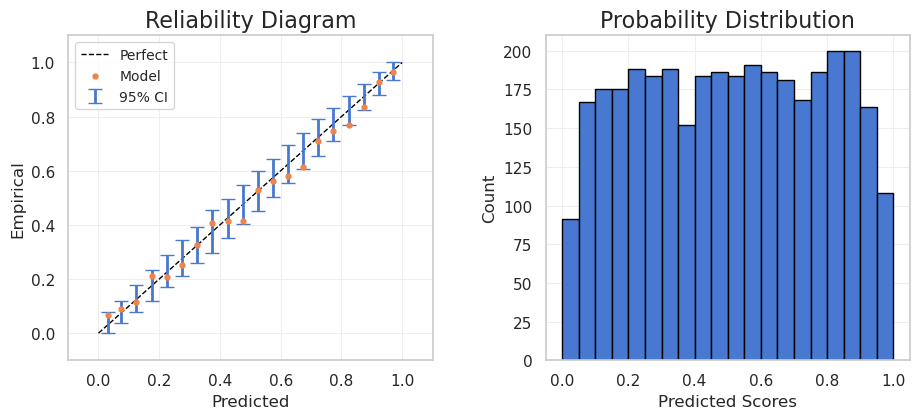

In [137]:
plt.figure(figsize=(10,5))
rd = mli.plot_reliability_diagram(y_test, y_prob_uncalib_test, show_histogram=True)

Les probabilités semblent déjà assez bien calibrées.

## Stratégie A: set de calibration

### Méthode Platt

In [138]:
# Fit Platt scaling (logistic calibration)
lr = LogisticRegression(C=99999999999, solver='lbfgs')
lr.fit(y_prob_uncalib_calib.reshape(-1,1), y_calib)

LogisticRegression(C=99999999999)

In [139]:
y_prob_platt_calib = lr.predict_proba(y_prob_uncalib_calib.reshape(-1,1))[:,1]
y_prob_platt_test = lr.predict_proba(y_prob_uncalib_test.reshape(-1,1))[:,1]

Text(0.5, 1.0, 'Calibration curve "Platt" sur les données de test')

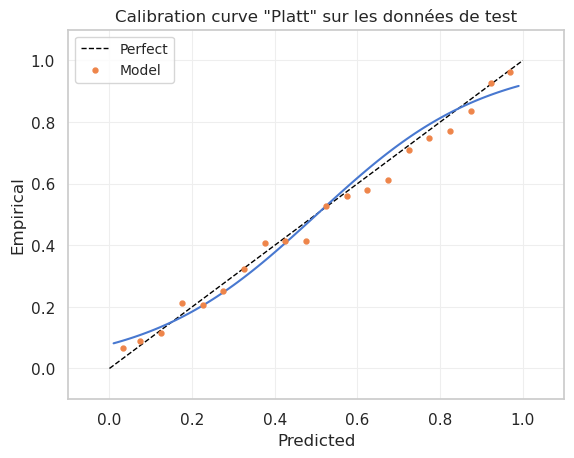

In [140]:
mli.plot_reliability_diagram(y_test, y_prob_uncalib_test, error_bars=False)
tvec = np.linspace(.01, .99, 99)
plt.plot(tvec, lr.predict_proba(tvec.reshape(-1,1))[:,1])
plt.title('Calibration curve "Platt" sur les données de test')

La sigmoïde tracée sur le graphe est la courbe de calibration de Platt: c'est une approximation de la relation entre les prédictions de probabilité de sortie de notre modèle et la probabilité réelle que la classe positive soit correcte.

Text(0.5, 1.0, 'Calibration curve "Platt" sur les données de test après calibration')

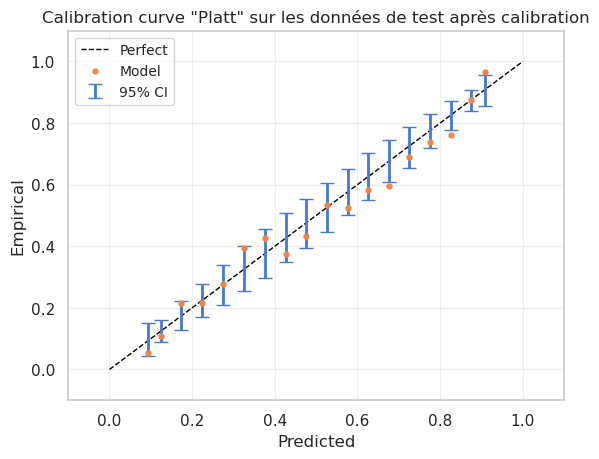

In [141]:
mli.plot_reliability_diagram(y_test, y_prob_platt_test)
plt.title('Calibration curve "Platt" sur les données de test après calibration')

In [142]:
print('Log-loss non-calibrée = {}'.format(log_loss(y_test, y_prob_uncalib_test)))
print('Log-loss calibrée avec Platt = {}'.format(log_loss(y_test, y_prob_platt_test)))

Log-loss non-calibrée = 0.5421769398204449
Log-loss calibrée avec Platt = 0.5448704153297083


La calibration avec le set de calibration et la méthode Platt ne semble pas améliorer la performance de la prédiction des probabilités.

### Régression isotonique

In [143]:
iso = IsotonicRegression(out_of_bounds = 'clip')
iso.fit(y_prob_uncalib_calib, y_calib)

IsotonicRegression(out_of_bounds='clip')

In [144]:
y_prob_iso_calib = iso.predict(y_prob_uncalib_calib)
y_prob_iso_test = iso.predict(y_prob_uncalib_test)

Text(0.5, 1.0, 'Calibration curve "Isotonic regression" sur les données de test')

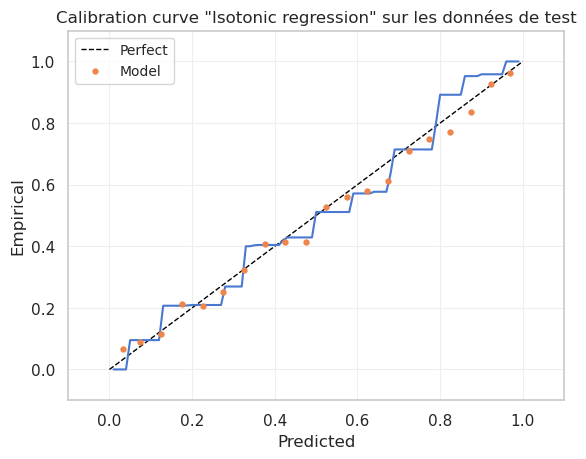

In [145]:
mli.plot_reliability_diagram(y_test, y_prob_uncalib_test, error_bars=False)
tvec = np.linspace(.01, .99, 99)
plt.plot(tvec, iso.predict(tvec), label='Isotonic')
plt.title('Calibration curve "Isotonic regression" sur les données de test')

Lorsque nous utilisons la régression isotonique pour calibrer un modèle, la fonction de régression isotonique ajustée peut également être tracée sur le graphe. Cette courbe représente la relation empirique entre les prévisions du modèle et les observations réelles.

Text(0.5, 1.0, 'Calibration curve "Isotonic regression" sur les données de test après calibration')

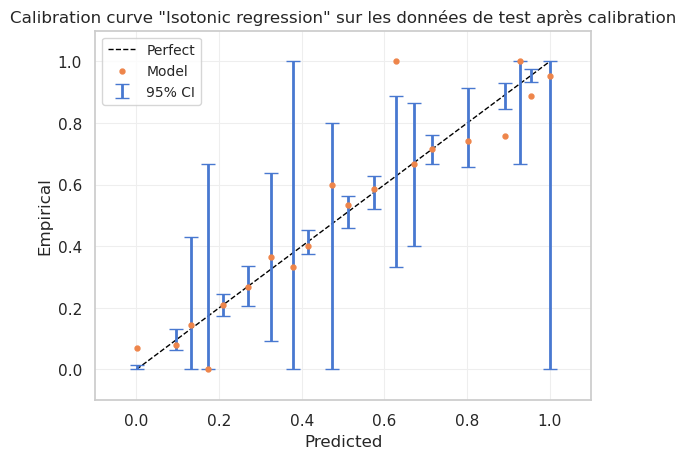

In [146]:
mli.plot_reliability_diagram(y_test, y_prob_iso_test)
plt.title('Calibration curve "Isotonic regression" sur les données de test après calibration')

In [147]:
print('Log-loss non-calibrée = {}'.format(log_loss(y_test, y_prob_uncalib_test)))
print('Log-loss calibrée avec Platt = {}'.format(log_loss(y_test, y_prob_platt_test)))
print('Log-loss calibrée avec régression isotonique = {}'.format(log_loss(y_test, y_prob_iso_test)))

Log-loss non-calibrée = 0.5421769398204449
Log-loss calibrée avec Platt = 0.5448704153297083
Log-loss calibrée avec régression isotonique = 0.6240436523612711


La calibration avec une approche de régression isotonique semble diminuer la capacité de prédiction des probabilités de notre modèle.

## Stratégie B: Validation croisée

In [148]:
df_X_train = pd.DataFrame(X_train)
cv_preds_train = mli.cv_predictions(model, df_X_train, y_train, clone_model=True)
cv_preds_train = cv_preds_train[:,1]

### Méthode Platt

In [149]:
# Fit Platt scaling (logistic calibration)
lr_cv = LogisticRegression(C=99999999999, solver='lbfgs')
lr_cv.fit(cv_preds_train.reshape(-1,1), y_train)

LogisticRegression(C=99999999999)

In [150]:
cv_prob_platt_test = lr_cv.predict_proba(y_prob_uncalib_test.reshape(-1,1))[:,1]

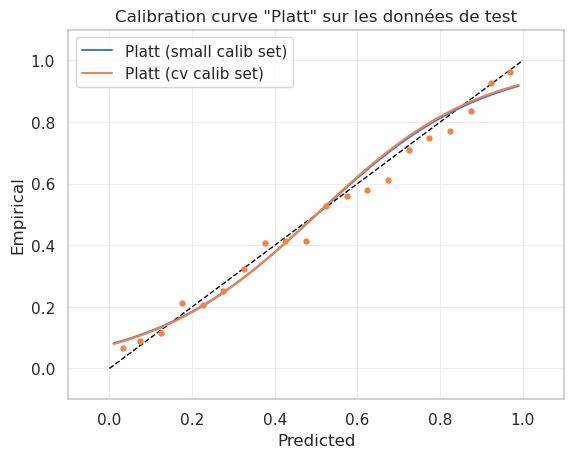

In [151]:
mli.plot_reliability_diagram(y_test, y_prob_uncalib_test, error_bars=False)
tvec = np.linspace(.01, .99, 99)
plt.plot(tvec, lr.predict_proba(tvec.reshape(-1,1))[:,1], label='Platt (small calib set)')
plt.plot(tvec, lr_cv.predict_proba(tvec.reshape(-1,1))[:,1], label='Platt (cv calib set)')
plt.title('Calibration curve "Platt" sur les données de test')
plt.legend()

Text(0.5, 1.0, 'Calibration curve "Platt" sur les données de test après calibration')

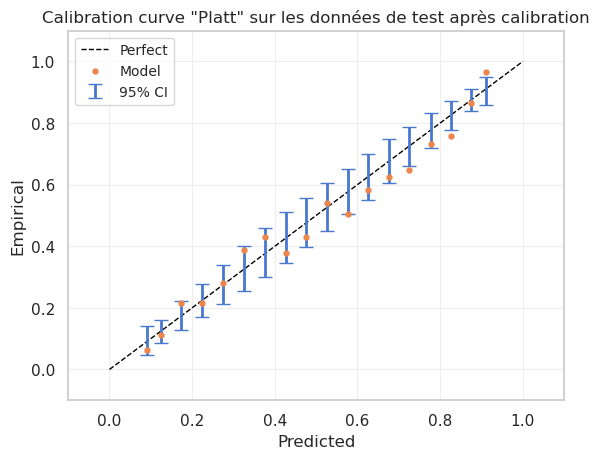

In [152]:
mli.plot_reliability_diagram(y_test, cv_prob_platt_test)
plt.title('Calibration curve "Platt" sur les données de test après calibration')

In [153]:
print('Log-loss non-calibrée = {}'.format(log_loss(y_test, y_prob_uncalib_test)))
print('Log-loss calibrée avec Platt = {}'.format(log_loss(y_test, cv_prob_platt_test)))

Log-loss non-calibrée = 0.5421769398204449
Log-loss calibrée avec Platt = 0.5452601553965116


### Régression isotonique

In [154]:
iso_cv = IsotonicRegression(out_of_bounds = 'clip')
iso_cv.fit(cv_preds_train, y_train)

IsotonicRegression(out_of_bounds='clip')

In [155]:
cv_prob_iso_test = iso_cv.predict(y_prob_uncalib_test)

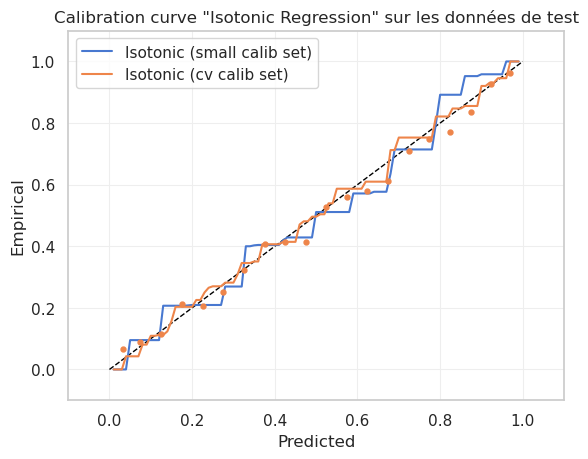

In [156]:
mli.plot_reliability_diagram(y_test, y_prob_uncalib_test, error_bars=False)
tvec = np.linspace(.01, .99, 99)
plt.plot(tvec, iso.predict(tvec), label='Isotonic (small calib set)')
plt.plot(tvec, iso_cv.predict(tvec), label='Isotonic (cv calib set)')
plt.title('Calibration curve "Isotonic Regression" sur les données de test')
plt.legend()

Text(0.5, 1.0, 'Calibration curve "Isotonic regression" sur les données de test après calibration')

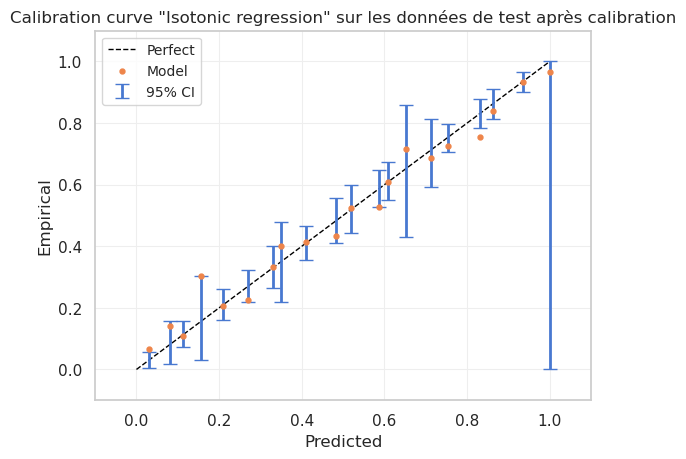

In [157]:
mli.plot_reliability_diagram(y_test, cv_prob_iso_test)
plt.title('Calibration curve "Isotonic regression" sur les données de test après calibration')

In [158]:
print('Log-loss non-calibrée = {}'.format(log_loss(y_test, y_prob_uncalib_test)))
print('Log-loss calibrée avec Platt = {}'.format(log_loss(y_test, cv_prob_platt_test)))
print('Log-loss calibrée avec régression isotonique = {}'.format(log_loss(y_test, cv_prob_iso_test)))

Log-loss non-calibrée = 0.5421769398204449
Log-loss calibrée avec Platt = 0.5452601553965116
Log-loss calibrée avec régression isotonique = 0.5800022823537326


La calibration avec la régression isotonique semble toujours diminuer les performances de notre modèle, mais l'approche B confère de meilleurs résultats que l'approche A.

# Conclusion

Nos modèles ont tous une performance satisfaisante bien meilleure que le hasard. Nous avons retenu le modèle de régression logistique, et nous avons joué avec le pré-processing pour garder les variables les plus intéressantes.

La calibration de nos données n'a pas aidé à augmenter les performances de nos modèles. Cependant, il est courant que la calibration des probabilités d'un modèle entraîne une légère dégradation des performances en termes de métriques telles que la log_loss. Mais il est également important de noter que la calibration peut aider à améliorer la fiabilité des prévisions du modèle en permettant une meilleure estimation de la probabilité d'un événement.

En ce qui concerne les options de calibration que nous avons utilisées, la calibration de Platt et la régression isotonique sont deux méthodes courantes. La calibration de Platt est une méthode simple mais moins précise, tandis que la régression isotonique est plus précise mais plus complexe. L'approche B, utilisant une cross-validation sur nos données d'entraînement, semble de manière générale plus performante que l'approche A.

Pour améliorer notre modèle, nous pourrions explorer d'autres méthodes de calibration.